In [1]:
from typing import Optional

import numpy as np
import cv2
import torch
import matplotlib.pyplot as plt

In [2]:
def positional_encoding(
    tensor, num_encoding_functions=6, include_input=True, log_sampling=True
) -> torch.Tensor:
  r"""Apply positional encoding to the input.

  Args:
    tensor (torch.Tensor): Input tensor to be positionally encoded.
    num_encoding_functions (optional, int): Number of encoding functions used to
        compute a positional encoding (default: 6).
    include_input (optional, bool): Whether or not to include the input in the
        computed positional encoding (default: True).
    log_sampling (optional, bool): Sample logarithmically in frequency space, as
        opposed to linearly (default: True).

  Returns:
    (torch.Tensor): Positional encoding of the input tensor.
  """
  # TESTED
  # Trivially, the input tensor is added to the positional encoding.
  encoding = [tensor] if include_input else []
  # Now, encode the input using a set of high-frequency functions and append the
  # resulting values to the encoding.
  frequency_bands = None
  if log_sampling:
      frequency_bands = 2.0 ** torch.linspace(
          0.0,
          num_encoding_functions - 1,
          num_encoding_functions,
          dtype=tensor.dtype,
          device=tensor.device,
      )
  else:
      frequency_bands = torch.linspace(
          2.0 ** 0.0,
          2.0 ** (num_encoding_functions - 1),
          num_encoding_functions,
          dtype=tensor.dtype,
          device=tensor.device,
      )

  for freq in frequency_bands:
      for func in [torch.sin, torch.cos]:
          encoding.append(func(tensor * freq))

  # Special case, for no positional encoding
  if len(encoding) == 1:
      return encoding[0]
  else:
      return torch.cat(encoding, dim=-1)


In [3]:
class VeryTinyNerfModel(torch.nn.Module):
  r"""Define a "very tiny" NeRF model comprising three fully connected layers.
  """

  def __init__(self, filter_size=256, num_encoding_functions=6, num_hidden_layers=8):
    super(VeryTinyNerfModel, self).__init__()
    n_input_dims = 3
    # Input layer (default: 39 -> 256)
    input_size = n_input_dims + n_input_dims * 2 * num_encoding_functions
    self.input_layer = torch.nn.Linear(
        input_size, filter_size)
    # Hidden layers
    self.hidden_layers = []
    for i in range(num_hidden_layers):
      # if i == 2:
        # self.hidden_layers.append(torch.nn.Linear(filter_size + input_size, filter_size))
      # else:
        self.hidden_layers.append(torch.nn.Linear(filter_size, filter_size))
    # Output layer
    self.output_layer = torch.nn.Linear(filter_size, 3)
    # Short hand for torch.nn.functional.relu
    self.relu = torch.nn.functional.relu

  def forward(self, x):
    # input_x = x
    x = self.relu(self.input_layer(x))
    for i, hl in enumerate(self.hidden_layers):
      # if i == 2:
        # skip connection
        # x = torch.cat((x, input_x), 1)
      x = self.relu(hl(x))
    # Sigmoid on the output layer b/c RGB is 0-1
    x = torch.sigmoid(self.output_layer(x))
    return x

In [4]:
def get_minibatches(inputs: torch.Tensor, chunksize: Optional[int] = 1024 * 8):
  r"""
  Each element of the list (except possibly the last) has dimension `0` of length
  `chunksize`.
  """
  return [inputs[i:i + chunksize] for i in range(0, inputs.shape[0], chunksize)]


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_tensor_type('torch.cuda.FloatTensor' if torch.cuda.is_available() else 'torch.FloatTensor')


In [6]:
cap = cv2.VideoCapture("../datasets/00003.mp4")
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)



def get_frame(idx):
  r""" Get the RGB tensor of a specific frame in the video.
  """
  cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
  success, img = cap.read()
  if not success:
    print("Failed to load frame at index " + str(idx))
  return torch.from_numpy(np.float32(img) / 255)


In [7]:
def xs_and_ys(width, height, frame_ind):
    r""" Construct (x, y, f) tuples.
    """
    res = []
    for y in range(height):
        for x in range(width):
            res.append([y / height, x / width, frame_ind])
    return torch.from_numpy(np.array(res, dtype=np.float32))

In [8]:
def one_iter_npc(width, height, model, frame_ind, encoding_fn, get_minibatches_fn):

  pts = xs_and_ys(width, height, frame_ind)

  encoded_pts = encoding_fn(pts)
  batches = get_minibatches_fn(encoded_pts)

  predictions = []
  for batch in batches:
    predictions.append(model(batch))
  
  rgb_flat = torch.cat(predictions, dim=0)
  rgb = torch.reshape(rgb_flat, [height, width, 3])
  return rgb

In [9]:
def output_video(fps, width: int, height: int, encode, get_minibatches):
  r"""Build the final video from the trained model."""
  out = cv2.VideoWriter('output_video.mp4', cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))

  def output_v(start_frame, end_frame, model):
    for f in range(start_frame, end_frame):
        rgb_predicted = one_iter_npc(width, height, model,
                                     f, encode,
                                     get_minibatches)

        rgb_out = cv2.normalize(src=rgb_predicted.detach().cpu().numpy(), dst=None, alpha=0, beta=255,
                                norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
        out.write(rgb_out)
    return lambda: out.release()

  return output_v

In [10]:
def get_new_chunk():
  model = VeryTinyNerfModel(num_encoding_functions=num_encoding_functions,
                            num_hidden_layers=num_hidden_layers, filter_size=filter_size)

  model.to(device)

  optimizer = torch.optim.Adam(model.parameters(), lr=lr)

  # Lists to log metrics etc.
  psnrs = []
  iternums = []

  all_psnrs = {}


  def training_loop(start_frame, end_frame, outputter):
    nonlocal model 
    nonlocal optimizer
    nonlocal psnrs
    nonlocal iternums
    nonlocal all_psnrs

    chunk_frames = end_frame - start_frame
    test_frame = end_frame

    print("Start frame: " + str(start_frame) + ", end frame: " + str(end_frame))
    print("Total frames: " + str(chunk_frames))

  

    for i in range(num_iters + 1):
      # Randomly pick a frame as the target
      target_frame_idx = np.random.randint(start_frame, end_frame)

      target_img = get_frame(target_frame_idx)
      
      rgb_predicted = one_iter_npc(width, height, model,
                                  target_frame_idx, encode,
                                  get_minibatches)

      # Compute mean-squared error between the predicted and target images. Backprop!
      loss = torch.nn.functional.mse_loss(rgb_predicted, target_img)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

      loss = torch.nn.functional.mse_loss(rgb_predicted, target_img)

    
      psnr = -10. * torch.log10(loss)
      all_psnrs[target_frame_idx] = psnr.item()

      # Display images/plots/stats
      if (i > 0) and (i % display_every == 0):
        # Render the held-out view
        rgb_predicted = one_iter_npc(width, height, model,
                                    test_frame, encode,
                                    get_minibatches)
        print("Loss:", loss.item())
        psnrs.append(psnr.item())
        iternums.append(i)
        plt.figure(figsize=(10, 4))
        plt.subplot(121)
        plt.imshow(rgb_predicted.detach().cpu().numpy())
        plt.title(f"Iteration {i}")
        plt.subplot(122)
        plt.imshow(get_frame(test_frame))
        # plt.plot(iternums, psnrs)
        plt.title("Original")
        plt.show()

    release_out = outputter(start_frame, end_frame, model)
    return release_out, list(all_psnrs.values())

  return training_loop

In [11]:
def chunk_processing(total_frames, outputter, initial_chunk_size=2, chunk_increment=2, absolute_basline=12, peak_psnr_percentage=0.85, train_loop = None):
    start_index = 0 

    if train_loop is None:
        train_loop = get_new_chunk()

    while start_index < total_frames:
        chunk_size = initial_chunk_size
        release_out, psnrs = train_loop(start_index, min(total_frames, start_index+chunk_size), outputter)
        peak_psnr = 0

        mean_psnr = np.mean(psnrs)

        while mean_psnr>absolute_basline and mean_psnr >= peak_psnr_percentage*peak_psnr:
            chunk_size += chunk_increment
            release_out, psnrs = train_loop(start_index, min(total_frames, start_index+chunk_size), outputter)
            mean_psnr = np.mean(psnrs)
            if mean_psnr > peak_psnr:
                peak_psnr = mean_psnr
            print(mean_psnr, absolute_basline, peak_psnr)

        start_index += chunk_size
        train_loop = get_new_chunk()
        
        
    return release_out

def get_baseline_psnr(total_frames, chunk_size):
    train_loop = get_new_chunk()
    # target_frame_idx = np.random.randint(0, total_frames)
    target_frame_idx = 0
    release_out, psnrs = train_loop(target_frame_idx, target_frame_idx+chunk_size, outputter)
    return np.mean(psnrs), train_loop



Video dims: 68x68
Framerate: 30.0
Start frame: 0, end frame: 1
Total frames: 1
Loss: 0.00045641022734344006


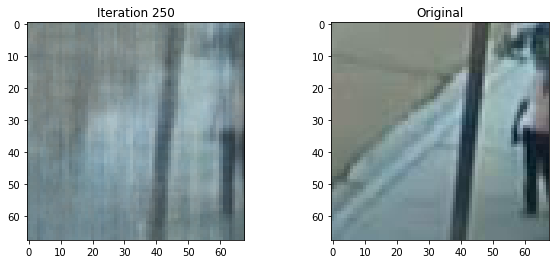

Loss: 0.00013432920968625695


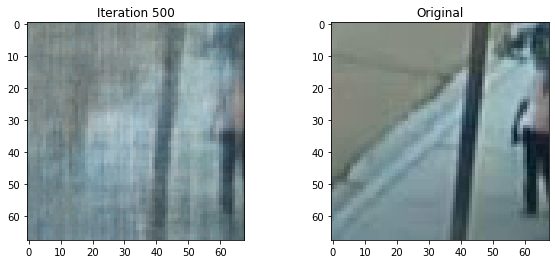

38.71829605102539
Start frame: 0, end frame: 2
Total frames: 2
Loss: 0.0002026556758210063


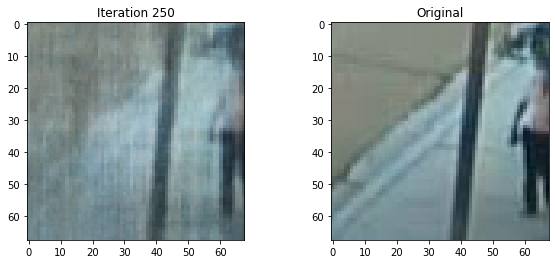

Loss: 0.00014673668192699552


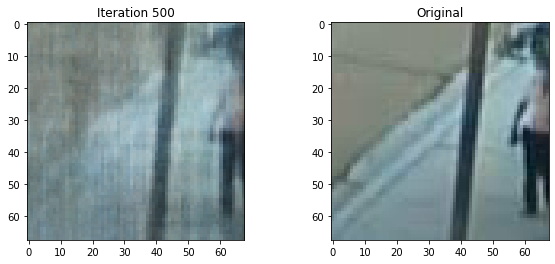

Start frame: 0, end frame: 4
Total frames: 4
Loss: 0.0002976030227728188


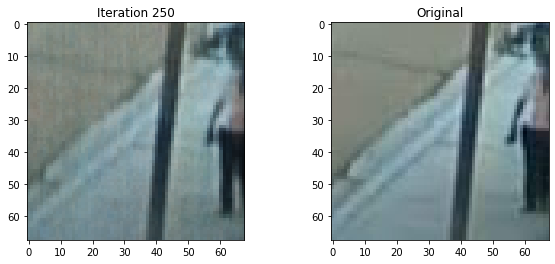

Loss: 0.0002395956398686394


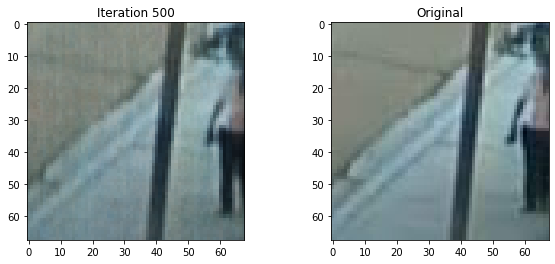

36.77035617828369 34.84646644592285 36.77035617828369
Start frame: 0, end frame: 6
Total frames: 6
Loss: 0.0007100163493305445


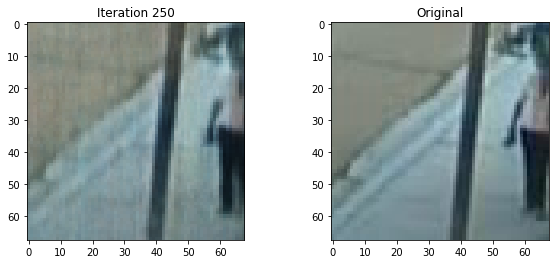

Loss: 0.00024392391787841916


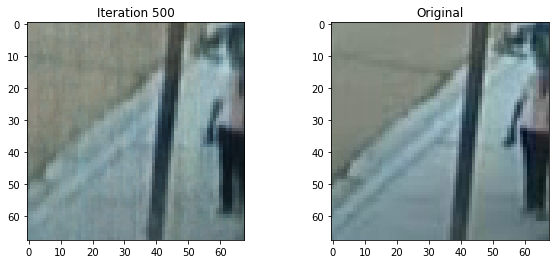

35.39365832010905 34.84646644592285 36.77035617828369
Start frame: 0, end frame: 8
Total frames: 8
Loss: 0.00041282863821834326


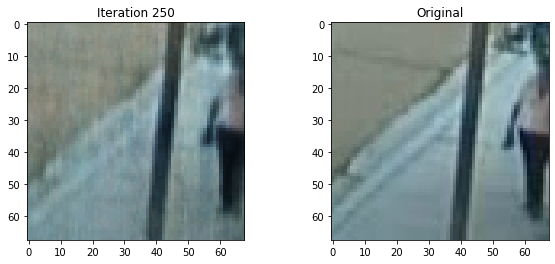

Loss: 0.0008169211796484888


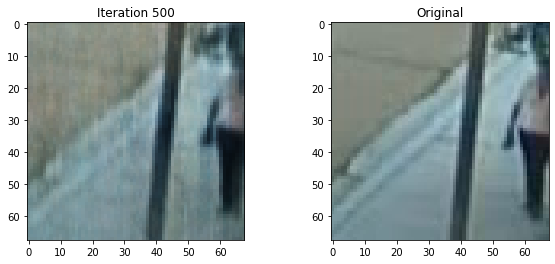

34.56499409675598 34.84646644592285 36.77035617828369
Start frame: 8, end frame: 10
Total frames: 2
Loss: 0.0009975648717954755


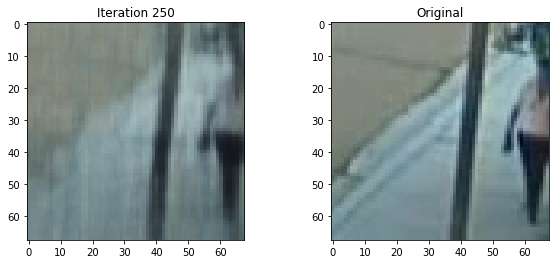

Loss: 0.0005592721281573176


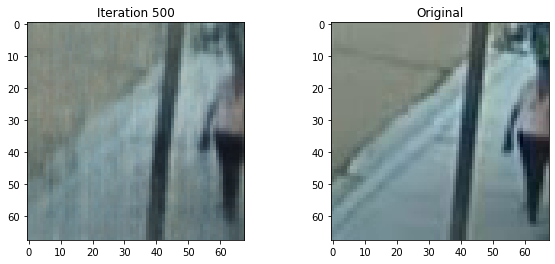

Start frame: 10, end frame: 12
Total frames: 2
Loss: 0.0012601648923009634


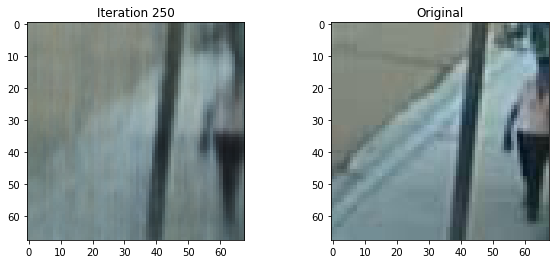

Loss: 0.0006131255649961531


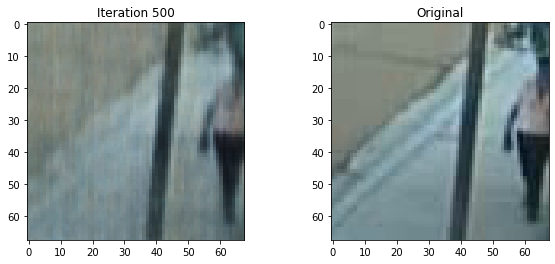

Start frame: 12, end frame: 14
Total frames: 2
Loss: 0.001275017624720931


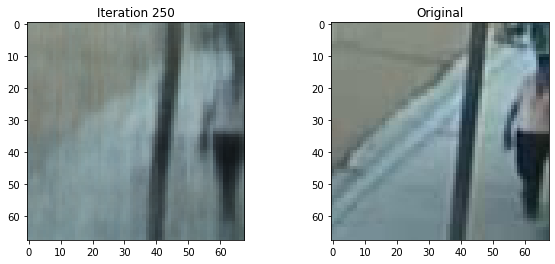

Loss: 0.0005442550173029304


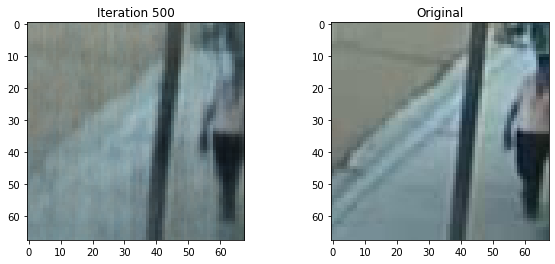

Start frame: 14, end frame: 16
Total frames: 2


In [12]:
"""
Parameters for NPC training
"""

num_hidden_layers = 4
filter_size = 256
# Number of functions used in the positional encoding (Be sure to update the
# model if this number changes).
num_encoding_functions = 9

# Specify encoding function.
def encode(x): return positional_encoding(
    x, num_encoding_functions=num_encoding_functions, include_input=True, log_sampling=True)

# Optimizer parameters
lr = 5e-3
num_iters = 500

# Misc parameters
display_every = 250  # Number of iters after which stats are displayed

"""
Train-Eval-Repeat!
"""

# Seed RNG, for repeatability
seed = 1337
torch.manual_seed(seed)
np.random.seed(seed)

total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
outputter = output_video(fps, width, height, encode, get_minibatches)

print("Video dims: " + str(width) + "x" + str(height))
print("Framerate: " + str(fps))

initial_chunk_size = 2

mean_psnr_one_fram, train_loop = get_baseline_psnr(total_frames, initial_chunk_size)


print(mean_psnr_one_fram)

release_out = chunk_processing(total_frames, outputter, initial_chunk_size = 2, absolute_basline = mean_psnr_one_fram*0.9, train_loop = train_loop)


print('Done training. Storing output...')
release_out()
print("Output complete")